# Red Queen Observation

## Imports

In [7]:
import sys
import os
import os.path
import io
import csv
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import gamma
from scipy import integrate
import seaborn as sns
import numpy.random as nprand
from scipy.stats import gamma

## Read file

In [10]:
def readfiles(pathtofile, file_name, ext_name,withoutneutral,withoutnan,minq,minfert,logfert,line_to_begin):
    data_file = pathtofile+file_name+"."+ext_name
    data = dict()
    params = []
    nbline=1
    with io.open(data_file,'r') as f:
        reader = csv.reader(f)
        firstline = True
        for line in reader:
            lin = line[0].split()
            if not firstline:
                if nbline>=line_to_begin:
                    for j in range(len(lin)):
                        if ext_name == "allele":
                            if float(lin[5])>minq and float(lin[6])>minfert:
                                if withoutneutral==1 and float(lin[1]) != -3 :
                                    if withoutnan == 0:
                                        if logfert==True and (j==6 or j==9):
                                            data[params[j]].append(np.log(float(lin[j])))
                                        else:
                                            data[params[j]].append(float(lin[j]))
                                    elif withoutnan ==1 :
                                        if lin[5]!="-nan" and lin[6]!="-nan":
                                            if logfert==True and (j==6 or j==9):
                                                data[params[j]].append(np.log(float(lin[j])))
                                            else:
                                                data[params[j]].append(float(lin[j])) 
                                elif withoutneutral==0:
                                    if withoutnan == 0:
                                        if logfert==True and (j==6 or j==9):
                                            data[params[j]].append(np.log(float(lin[j])))
                                        else:
                                            data[params[j]].append(float(lin[j]))
                                    elif withoutnan ==1 :
                                        if lin[5]!="-nan" and lin[6]!="-nan":
                                            if logfert==True and (j==6 or j==9):
                                                data[params[j]].append(np.log(float(lin[j])))
                                            else:
                                                data[params[j]].append(float(lin[j]))
                        elif ext_name == "trace" and logfert==True and (j==6 or j==14):
                            data[params[j]].append(np.log(float(lin[j])))
                        else :
                            data[params[j]].append(float(lin[j]))
                nbline=nbline+1
            else:
                for j in lin:
                    data[j]=[]
                    params.append(j)
                firstline = False
                nbline=nbline+1
    return (data)

### Colorblind palette

In [11]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  #'#999999', 
                  '#e41a1c', '#dede00']

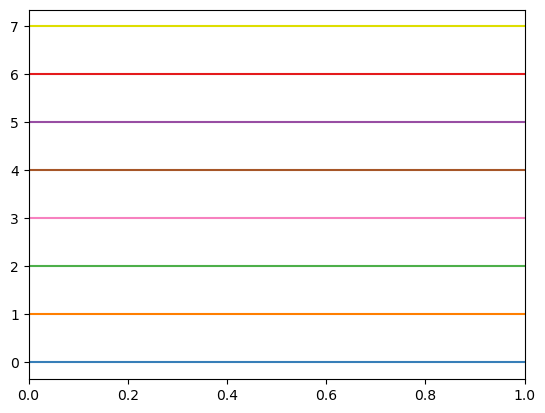

In [12]:
for i in range(len(CB_color_cycle)):
    plt.axhline(y=i,color=CB_color_cycle[i])

## Functions for plot

In [5]:
def graph_per_allele(target_folder_path, file_name, ext_name, x_axis_param, y_axis_param,withoutneutral,withoutnan,minq,minfert,logfert,line_to_begin):
    data_all = readfiles(target_folder_path, file_name, 'allele',withoutneutral,withoutnan,minq,minfert,logfert,line_to_begin)
    data_trace = readfiles(target_folder_path, file_name, "trace",withoutneutral,withoutnan,minq,minfert,logfert,line_to_begin)
    x_per_allele=dict()
    y_per_allele=dict()
    for i in range(len(data_all["Generation_number"])):
        cle = data_all['Allele_number'][i]
        if ((str(cle) in x_per_allele) == False and cle!=-3):
            x_per_allele[str(cle)]=[]
            x_per_allele[str(cle)].append(data_all[x_axis_param][i])
            y_per_allele[str(cle)]=[]
            if y_axis_param=="selection":
                sel_coef=np.log(data_all['fertility_analytic'][i])-np.log(data_trace['fertility_analytic'][int(data_all["Generation_number"][i]/100)])
                y_per_allele[str(cle)].append(sel_coef)
            else:
                y_per_allele[str(cle)].append(data_all[y_axis_param][i])
        elif ((str(cle) in x_per_allele) == True and cle!=-3):
            x_per_allele[str(cle)].append(data_all[x_axis_param][i])
            if y_axis_param=="selection":
                sel_coef=np.log(data_all['fertility_analytic'][i])-np.log(data_trace['fertility_analytic'][int(data_all["Generation_number"][i]/100)])
                y_per_allele[str(cle)].append(sel_coef)
            else:
                y_per_allele[str(cle)].append(data_all[y_axis_param][i])
    return(x_per_allele,y_per_allele)

### For separated plots

In [6]:
def plot_regim_per_allele(target_folder_path, file_name, ext_name, x_param, y_params, withoutneutral, withoutnan,minq,minfert,logfert,line_to_begin, allelenbmin, allelenbmax,boldallel,xmin,xmax,x_letter,y_letter,ymin,ymax,title,letters):
    index_line=1
    legend_list=["Frequency of\n PRDM9 alleles","Proportion of\n active sites","Selection\n Coefficient"]
    figure=plt.figure(figsize=(8,6))
    figure.patch.set_facecolor('white')
    figure.patch.set_alpha(0)
    for i in y_params:
        max_y=0
        plt.subplot(len(y_params),1,index_line) 
        (X,Y)=graph_per_allele(target_folder_path, file_name, ext_name, x_param, i, withoutneutral,withoutnan,minq,minfert,logfert,line_to_begin)
        index_color=0
        for j in range(allelenbmax-allelenbmin):
            allele_nb=allelenbmin+j
            nameallelelist=[str(allele_nb),'.0']
            nameallele=''.join(nameallelelist)
            if X.get(nameallele, 0)!=0:
                if(float(nameallele)==boldallel):
                    plt.plot(X[nameallele], Y[nameallele],linewidth=3,color=CB_color_cycle[index_color])
                else:
                    plt.plot(X[nameallele], Y[nameallele],color=CB_color_cycle[index_color])
                if(max_y<max(Y[nameallele])):
                    max_y=max(Y[nameallele])
                index_color+=1
                index_color=index_color%8
        plt.ylabel(legend_list[index_line-1],fontsize=11)
        plt.text(x=x_letter,y=y_letter[index_line-1],s=letters[index_line-1],fontweight='bold',fontsize=16)
        if index_line==len(y_params):
            plt.xlabel("Number of generations",fontsize=12)
        plt.title(title)
        if i=="selection":
            plt.axhline(y=0, color='black',linestyle=':')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.xlim(xmin,xmax)
        plt.ylim(ymin[index_line-1],ymax[index_line-1])
        plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.25)
        plt.grid()
        index_line+=1

In [4]:
path_to_file_init = "../../../analyses/"

## Without genetic dosage

### Parameters for the plot and Graphic

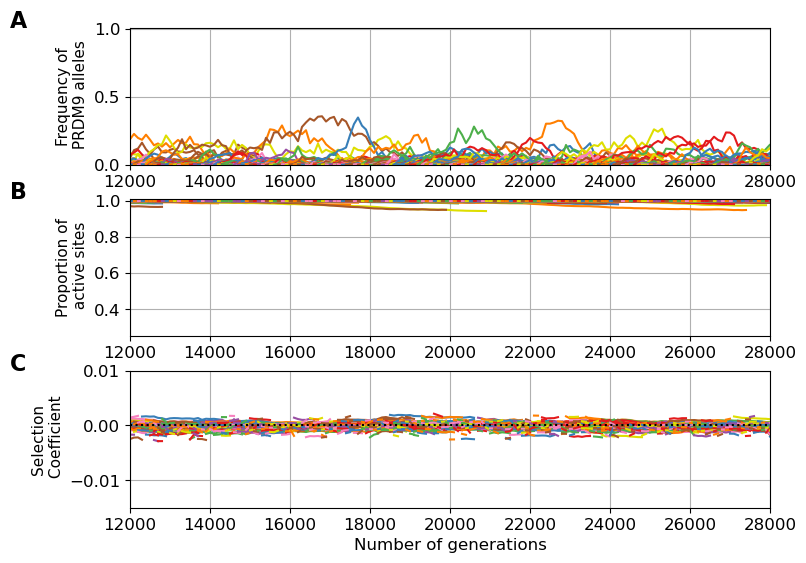

In [18]:
u="5e-4"
v="2e-6"
path_to_file_to_plot = "scaling_bidim_U_V/scaling_bidim_1/scaling_V_"+v+"/"
file_to_plot = "Run_U_"+u
ext_of_file = "allele"
x_parameter = "Generation_number"
y_parameters = ["Frequency","Activity","selection"]
withoutneutral = 0
withoutnan = 0
minq = 0
minfert = 0
logfert = 0
line_to_begin = 0
allelenbmin = 40000
allelenbmax = 2000000
boldallel = -1
xmin = 12000
xmax = 28000
ymin=[0,0.25,-0.015]
ymax=[1.01,1.01,0.01]
x_letter = 9000
y_letter =[1.01,1.01,0.01]
title=""
letters=["A","B","C"]
plot_regim_per_allele(path_to_file_init+path_to_file_to_plot, file_to_plot, ext_of_file, x_parameter,y_parameters,withoutneutral, withoutnan,minq,minfert,logfert,line_to_begin, allelenbmin, allelenbmax,boldallel,xmin,xmax,x_letter,y_letter,ymin,ymax,title,letters)

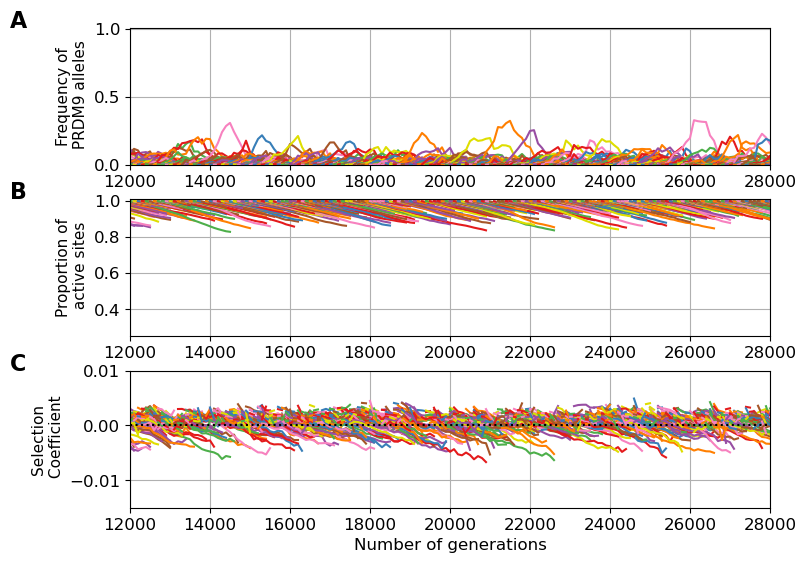

In [11]:
u="5e-4"
v="5e-5"
path_to_file_to_plot = "scaling_bidim_U_V/scaling_bidim_1/scaling_V_"+v+"/"
file_to_plot = "Run_U_"+u
ext_of_file = "allele"
x_parameter = "Generation_number"
y_parameters = ["Frequency","Activity","selection"]
#y_parameters = ["Frequency","Activity"]
withoutneutral = 0
withoutnan = 0
minq = 0
minfert = 0
logfert = 0
line_to_begin = 0
allelenbmin = 40000
allelenbmax = 2000000
boldallel = -1
xmin = 12000
xmax = 28000
ymin=[0,0.25,-0.015]
ymax=[1.01,1.01,0.01]
x_letter = 9000
y_letter =[1.01,1.01,0.01]
title=""
letters=["A","B","C"]
plot_regim_per_allele(path_to_file_init+path_to_file_to_plot, file_to_plot, ext_of_file, x_parameter,y_parameters,withoutneutral, withoutnan,minq,minfert,logfert,line_to_begin, allelenbmin, allelenbmax,boldallel,xmin,xmax,x_letter,y_letter,ymin,ymax,title,letters)

## With genetic dosage

### Parameters for the plot and Graphic

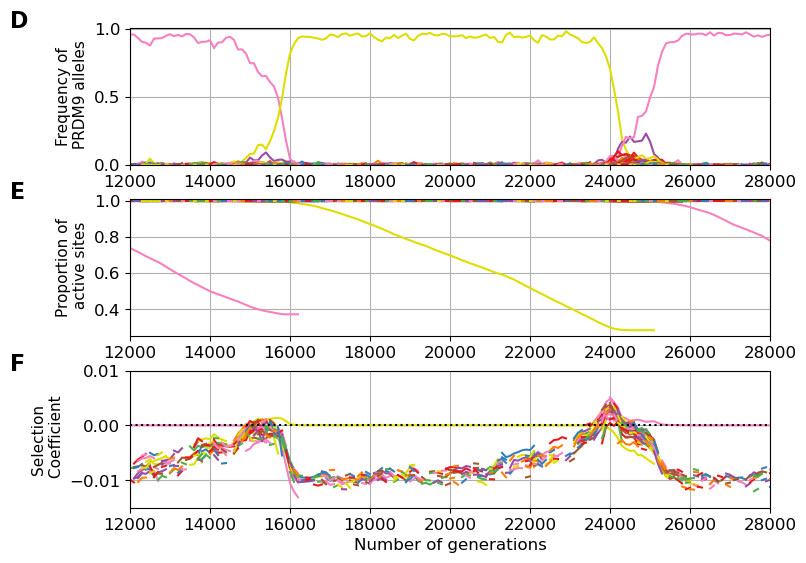

In [19]:
u="5e-4"
v="2e-6"
path_to_file_to_plot = "scaling_bidim_U_V/scaling_bidim_2/scaling_V_"+v+"/"
file_to_plot = "Run_U_"+u
ext_of_file = "allele"
x_parameter = "Generation_number"
y_parameters = ["Frequency","Activity","selection"]
#y_parameters = ["Frequency","Activity"]
withoutneutral = 0
withoutnan = 0
minq = 0
minfert = 0
logfert = 0
line_to_begin = 0
allelenbmin = 3500 #3520
allelenbmax = 300000
boldallel = -1
xmin = 12000
xmax = 28000
ymin=[0,0.25,-0.015]
ymax=[1.01,1.01,0.01]
x_letter = 9000
y_letter = [1.01,1.01,0.01]
title=""
letters=["D","E","F"]
plot_regim_per_allele(path_to_file_init+path_to_file_to_plot, file_to_plot, ext_of_file, x_parameter,y_parameters,withoutneutral, withoutnan,minq,minfert,logfert,line_to_begin, allelenbmin, allelenbmax,boldallel,xmin,xmax,x_letter,y_letter,ymin,ymax,title,letters)

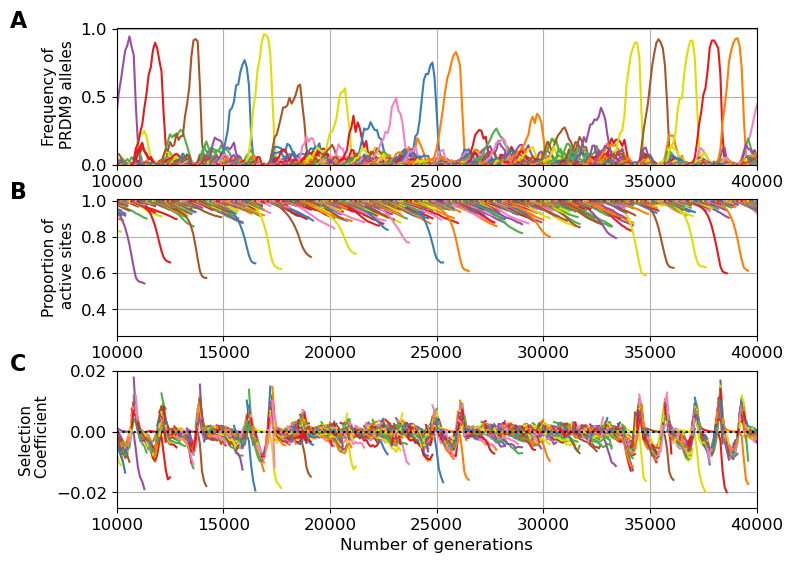

In [9]:
u="5e-4"
v="5e-5"
path_to_file_to_plot = "scaling_bidim_U_V/scaling_bidim_2/scaling_V_"+v+"/"
file_to_plot = "Run_U_"+u
ext_of_file = "allele"
x_parameter = "Generation_number"
y_parameters = ["Frequency","Activity","selection"]
#y_parameters = ["Frequency","Activity"]
withoutneutral = 0
withoutnan = 0
minq = 0
minfert = 0
logfert = 0
line_to_begin = 0
allelenbmin = 3500 #3520
allelenbmax = 300000
boldallel = -1
xmin = 10000#12000
xmax = 40000#28000
ymin=[0,0.25,-0.025]
ymax=[1.01,1.01,0.02]
x_letter = 5000#9000
y_letter = [1.01,1.01,0.02]
title=""
#letters=["D","E","F"]
letters=["A","B","C"]
plot_regim_per_allele(path_to_file_init+path_to_file_to_plot, file_to_plot, ext_of_file, x_parameter,y_parameters,withoutneutral, withoutnan,minq,minfert,logfert,line_to_begin, allelenbmin, allelenbmax,boldallel,xmin,xmax,x_letter,y_letter,ymin,ymax,title,letters)
plt.savefig('Fig5_v2.png', dpi=200, bbox_inches='tight')

## Functions for plot

### Unified plot

In [26]:
def plot_regim_per_allele_2(target_folder_path, file_name, ext_name, x_param, y_params, withoutneutral, withoutnan,minq,minfert,logfert,line_to_begin, allelenbmin, allelenbmax,boldallel,xmin,xmax,x_letter,y_letter,ymin,ymax,title,letters):
    #figure=plt.figure(figsize=(8,12))
    figure=plt.figure(figsize=(8,9))
    index_line_plot=1
    for k in range(2):
        index_line=1
        legend_list=["Frequency of\n PRDM9 alleles ("r"$f_i$)","Proportion of\n active sites ("r"$\theta_i$)","Selection\n Coefficient ("r"$s_i$)"]
        figure.patch.set_facecolor('white')
        figure.patch.set_alpha(0)
        for i in y_params:
            max_y=0
            plt.subplot(2*len(y_params),1,index_line_plot) 
            (X,Y)=graph_per_allele(target_folder_path[k], file_name[k], ext_name, x_param, i, withoutneutral,withoutnan,minq,minfert,logfert,line_to_begin)
            index_color=0 ###############
            for j in range(allelenbmax[k]-allelenbmin[k]):
                allele_nb=allelenbmin[k]+j
                nameallelelist=[str(allele_nb),'.0']
                nameallele=''.join(nameallelelist)
                if X.get(nameallele, 0)!=0:
                    if(float(nameallele)==boldallel[k]):
                        plt.plot(X[nameallele], Y[nameallele],linewidth=3,color=CB_color_cycle[index_color])#linewidth=6 ##########
                    else:
                        plt.plot(X[nameallele], Y[nameallele],color=CB_color_cycle[index_color])########################
                    if(max_y<max(Y[nameallele])):
                        max_y=max(Y[nameallele])
                    index_color+=1###############
                    index_color=index_color%8################
            plt.ylabel(legend_list[index_line-1],fontsize=11)
            plt.text(x=x_letter,y=y_letter[k][index_line-1],s=letters[k][index_line-1],fontweight='bold',fontsize=16)
            if index_line==len(y_params):
                plt.xlabel("Number of generations",fontsize=12)
            plt.title(title)
            if i=="selection":
                plt.axhline(y=0, color='black',linestyle=':')
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
            plt.xlim(xmin,xmax)
            plt.ylim(ymin[k][index_line-1],ymax[k][index_line-1])
            plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.25)
            index_line+=1
            index_line_plot+=1
            plt.grid()#############
            figure.tight_layout()

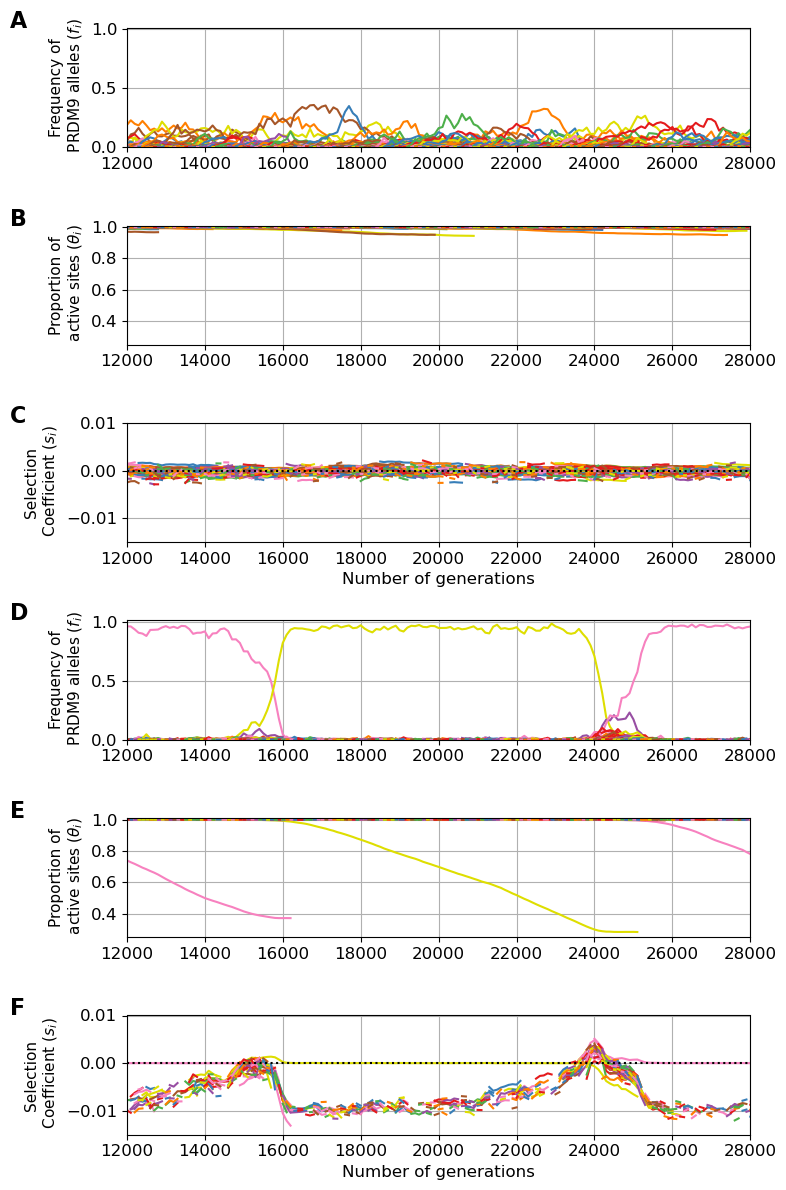

In [23]:
u_1="5e-4"
v_1="2e-6"
path_to_file_to_plot_1 = "scaling_bidim_U_V/scaling_bidim_1/scaling_V_"+v_1+"/"
file_to_plot_1 = "Run_U_"+u_1
u_2="5e-4"
v_2="2e-6"
path_to_file_to_plot_2 = "scaling_bidim_U_V/scaling_bidim_2/scaling_V_"+v_2+"/"
file_to_plot_2 = "Run_U_"+u_2
ext_of_file = "allele"
x_parameter = "Generation_number"
y_parameters = ["Frequency","Activity","selection"]
withoutneutral = 0
withoutnan = 0
minq = 0
minfert = 0
logfert = 0
line_to_begin = 0
allelenbmin_1 = 40000
allelenbmax_1 = 2000000
boldallel_1 = -1
allelenbmin_2 = 350 #3520
allelenbmax_2 = 300000
boldallel_2 = -1
xmin = 12000
xmax = 28000
ymin_1=[0,0.25,-0.015]
ymax_1=[1.01,1.01,0.01]
x_letter = 9000
y_letter_1 =[1.01,1.01,0.01]
title=""
letters_1=["A","B","C"]
ymin_2=[0,0.25,-0.015]
ymax_2=[1.01,1.01,0.01]
x_letter = 9000
y_letter_2 = [1.01,1.01,0.01]
title=""
letters_2=["D","E","F"]

target_folder_path = [path_to_file_init+path_to_file_to_plot_1,path_to_file_init+path_to_file_to_plot_2]
file_to_plot = [file_to_plot_1,file_to_plot_2]
allelenbmin = [allelenbmin_1,allelenbmin_2]
allelenbmax = [allelenbmax_1,allelenbmax_2]
boldallel = [boldallel_1,boldallel_2]
ymin = [ymin_1,ymin_2]
ymax = [ymax_1,ymax_2]
y_letter = [y_letter_1,y_letter_2]
letters = [letters_1,letters_2]

fig1=plot_regim_per_allele_2(target_folder_path, file_to_plot, ext_of_file, x_parameter,y_parameters,withoutneutral, withoutnan,minq,minfert,logfert,line_to_begin, allelenbmin, allelenbmax,boldallel,xmin,xmax,x_letter,y_letter,ymin,ymax,title,letters)

plt.savefig('Fig6.png', dpi=200, bbox_inches='tight') #, transparent = True


**Caption : PRDM9 dynamic : example of a PRDM9 dynamic without PRDM9 genetic dosage (A) to
(C) and with genetic dosage (D) to (F) (u = 5 × 10−4 and v = 2 × 10−6).** In all the graphs, each color
corresponds to a different allele. Note that a given color can be reasigned to a new allele later in the
simulation. This figure represents the evolution along time of (A),(D) the frequency of each PRDM9 allele
and their corresponding (B),(E) proportion of active sites and (C),(F) selection coefficient. Here, the
genetic dosage changes the regime of the dynamic passing it from polymorphic to monomorphic.

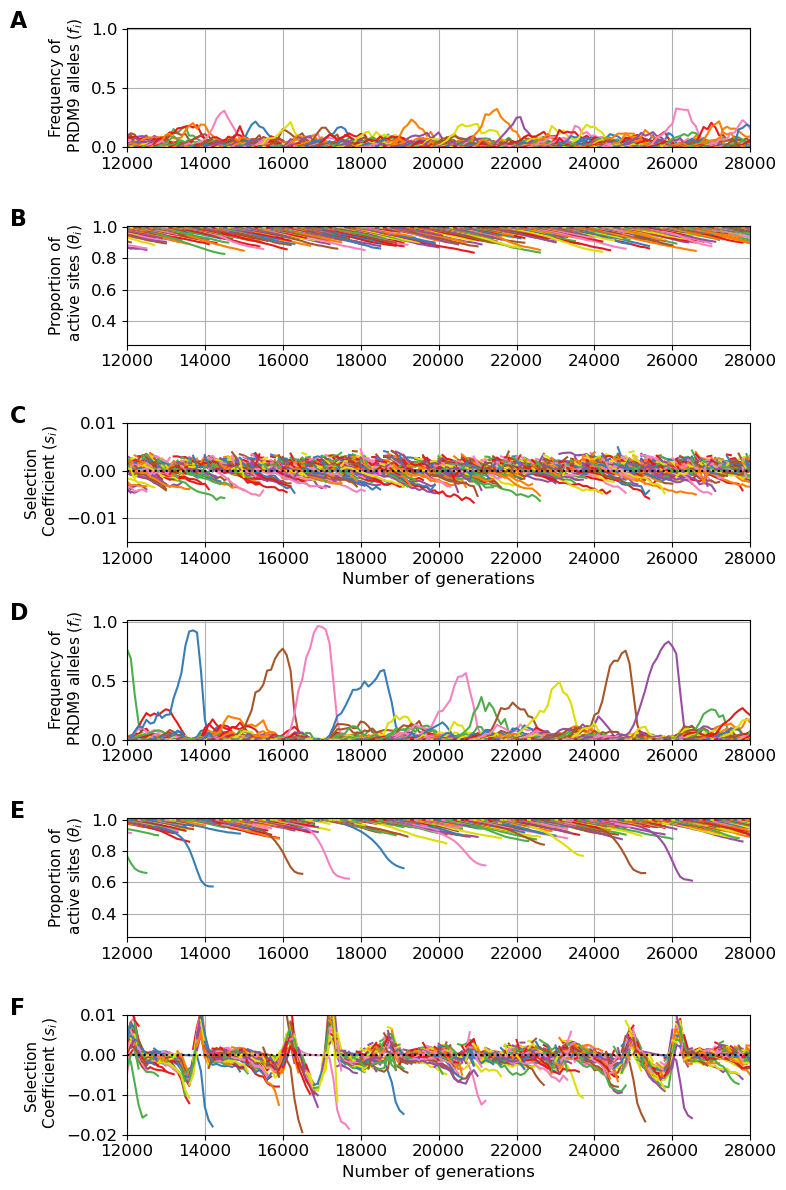

In [25]:
u_1="5e-4"
v_1="5e-5"
path_to_file_to_plot_1 = "scaling_bidim_U_V/scaling_bidim_1/scaling_V_"+v_1+"/"
file_to_plot_1 = "Run_U_"+u_1
u_2="5e-4"
v_2="5e-5"
path_to_file_to_plot_2 = "scaling_bidim_U_V/scaling_bidim_2/scaling_V_"+v_2+"/"
file_to_plot_2 = "Run_U_"+u_2
ext_of_file = "allele"
x_parameter = "Generation_number"
y_parameters = ["Frequency","Activity","selection"]
withoutneutral = 0
withoutnan = 0
minq = 0
minfert = 0
logfert = 0
line_to_begin = 0
allelenbmin_1 = 40000
allelenbmax_1 = 2000000
boldallel_1 = -1
allelenbmin_2 = 350 #3520
allelenbmax_2 = 300000
boldallel_2 = -1
xmin = 12000
xmax = 28000
ymin_1=[0,0.25,-0.015]
ymax_1=[1.01,1.01,0.01]
x_letter = 9000
y_letter_1 =[1.01,1.01,0.01]
title=""
letters_1=["A","B","C"]
ymin_2=[0,0.25,-0.02]
ymax_2=[1.01,1.01,0.01]
x_letter = 9000
y_letter_2 = [1.01,1.01,0.01]
title=""
letters_2=["D","E","F"]

target_folder_path = [path_to_file_init+path_to_file_to_plot_1,path_to_file_init+path_to_file_to_plot_2]
file_to_plot = [file_to_plot_1,file_to_plot_2]
allelenbmin = [allelenbmin_1,allelenbmin_2]
allelenbmax = [allelenbmax_1,allelenbmax_2]
boldallel = [boldallel_1,boldallel_2]
ymin = [ymin_1,ymin_2]
ymax = [ymax_1,ymax_2]
y_letter = [y_letter_1,y_letter_2]
letters = [letters_1,letters_2]

fig1=plot_regim_per_allele_2(target_folder_path, file_to_plot, ext_of_file, x_parameter,y_parameters,withoutneutral, withoutnan,minq,minfert,logfert,line_to_begin, allelenbmin, allelenbmax,boldallel,xmin,xmax,x_letter,y_letter,ymin,ymax,title,letters)

plt.savefig('Fig6_bis.png', dpi=200, bbox_inches='tight') #, transparent = True


In [13]:
def dico_data(target_folder_path,x_params,y_params, file_ext, withneutral,withoutnan,withlog,initline):
    list_files = sorted(os.listdir(target_folder_path))
    dico_file = dict()
    list_namefile=[]
    for file_name in list_files :
        if file_name.split(".")[1]==file_ext :
            if withneutral==1:
                data_file=readfiles(target_folder_path, file_name.split(".")[0], file_name.split(".")[1],0,withoutnan)
            elif withneutral==0:
                data_file=readfiles(target_folder_path, file_name.split(".")[0], file_name.split(".")[1],1,withoutnan,0,0,withlog,initline)
            if  x_params in data_file and y_params in data_file :
                dico_file[(file_name.split(".")[0]).split("_")[-1]+"_x_params"]=data_file[x_params]
                dico_file[(file_name.split(".")[0]).split("_")[-1]+"_y_params"]=data_file[y_params]
            list_namefile.append((file_name.split(".")[0]).split("_")[2])
    list_namefile=sorted(list(set(list_namefile)))
    return (list_namefile,dico_file)

In [24]:
u="5e-4"
v="5e-5"
N=5000
list_namefile,dico_file=dico_data(path_to_file_init+"scaling_bidim_U_V/scaling_bidim_1/scaling_V_"+v+"/","Age","fertility_analytic","allele",0,1,False,0)
list_namefile1,dico_file1=dico_data(path_to_file_init+"scaling_bidim_U_V/scaling_bidim_1/scaling_V_"+v+"/","Frequency","fertility_analytic","allele",0,1,False,0)
list_namefile2,dico_file2=dico_data(path_to_file_init+"scaling_bidim_U_V/scaling_bidim_1/scaling_V_"+v+"/","Generation_number","fertility_analytic","trace",0,1,False,0)


S0=[]
index=0
I=[]
fourNS0=[]
for i in list_namefile :
    print(i," : ")
    I.append(float(i))
    mean_fert_0=0
    n=len(dico_file[i+"_x_params"])
    if n==0 :
        mean_fert_0=0  
    else:
        m=min(dico_file[i+"_x_params"])
        ntot=0
        for j in range(n):
            if dico_file[i+"_x_params"][j]==m and dico_file[i+"_y_params"][j]!=0:
                mean_fert_0+=dico_file[i+"_y_params"][j]
                ntot+=1
        mean_fert=np.mean(dico_file2[i+"_y_params"])
        #s0_coeff=np.log(mean_fert_0/ntot)-np.log(np.mean(dico_file[i+"_y_params"]))
        s0_coeff=np.log(mean_fert_0/ntot)-np.log(mean_fert)
        print("s0 = ",s0_coeff)
    S0.append(s0_coeff)
    fourNS0.append(max(4*N*S0[index],0))
    print('4Ns0 = ',fourNS0[index])
    index+=1



2e-3  : 
s0 =  0.0006948685033982514
4Ns0 =  13.897370067965028
2e-4  : 
s0 =  0.0027610666465005852
4Ns0 =  55.221332930011705
2e-5  : 
s0 =  0.006357720822941192
4Ns0 =  127.15441645882383
2e-6  : 
s0 =  0.020299516331535594
4Ns0 =  405.9903266307119
5e-3  : 
s0 =  0.0003286634348449481
4Ns0 =  6.573268696898962
5e-4  : 
s0 =  0.0017178292723317341
4Ns0 =  34.35658544663468
5e-5  : 
s0 =  0.004447343368797558
4Ns0 =  88.94686737595116
5e-6  : 
s0 =  0.012250424487227907
4Ns0 =  245.00848974455812
